In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize
import scipy.stats
import random
from scipy.stats import norm
from scipy.optimize import minimize
import time

# Maximum Likelihood Estimation for Ornstein-Uhlenbeck Processes

Author: Kaiwen Zhang, Shi Feng, Wencheng Bao

In this demo, we implement the Maximum Likelihood Estimation (MLE) method for parameter inference in the Ornstein-Uhlenbeck (OU) process. In the case of purely Brownian noise, the task is simple because the likelihood function can be computed analytically.

## 1. OU Process with Purely Brownian Noise

We follow the formula $$dX_t = \theta (\mu - X_t) dt + \sigma dW_t$$ for OU process, and discretize the SDE with the Euler-Maruyama method. The resulting discrete scheme is: $$X_{i+1} = X_i + \theta (\mu - X_i)dt + \sigma Z_i$$ where $Z_i \sim N(0, dt)$, $dt$ is variance.

With a given time series data generated by the above SDE, the likelihood function of paramaters can be computed using the condition densities $p(X_{i+1}|X_i)$. Indeed, with $X_i$ given, $X_{i+1}$ follows a normal distribution centered at $X_i + \theta(\mu - X_i) dt$, with variance $\sigma^2 dt$.

Note: because the large size of data, it is not practical to compute the exact likelihood function. We instead compute the log likelihood function. Since logarithm is monotone, optimizing the log likelihood is equivalent to optimizing likelihood.

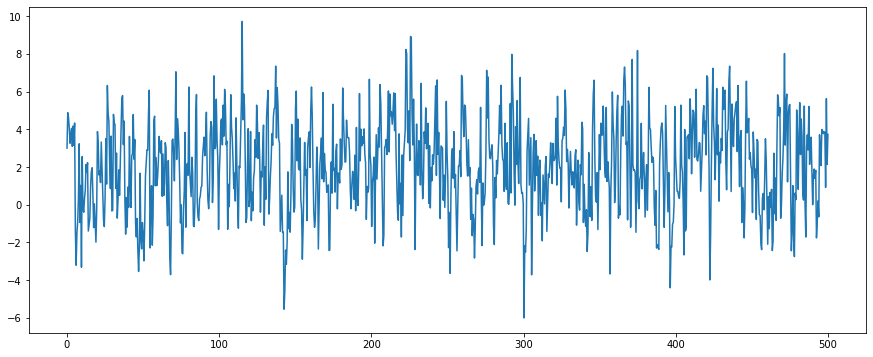

In [2]:
# genrate data, OU process discretized
# dX_t = theta (mu - X_t) dt + sigma dW_t
N = 1000 # data size
t = np.linspace(0, 500, N) # time

# set parameters manually first, we look to reconstruct them
theta = 1
mu = 2
sigma = 3
x_init = 3 # the first data point, manually set and not reconstructed

# Euler-Maruyama simulation of OU process
def sim_OU(params, time):
    """
    Input:
    - params: parameters in the model, follow the order [theta, mu, sigma, x_init]
    - time: a numpy array of time variable, used to compute dt
    Output:
    - a numpy array of length time.size, consisting of simulated OU process
    """
    theta, mu, sigma, x_init = (params[0], params[1], params[2], params[3])
    res = np.zeros(time.shape[0])
    res[0] = x_init
    for i in range(time.shape[0] - 1):
        dt = time[i+1] - time[i]
        res[i+1] = res[i] + theta * (mu - res[i]) * dt + sigma * np.random.normal(0, np.sqrt(dt))
    return res

X = sim_OU(params=[theta, mu, sigma, x_init], time = t)
# plot data
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X)

In [4]:
# construct likelihood function

def normal_pdf(mean, var, x):
    """
    a function for computing the normal pdf value at given point
    """
    return (1 / (np.sqrt(2 * np.pi * var))) * np.exp(- 0.5 * ((x - mean)/np.sqrt(var))**2)

def neg_log_likelihood(params, data, time):
    """
    Computes the negative log likelihood function given the time series data, to be minimized
    Input:
    - params: parameters of the SDE, in order [theta, mu, sigma]
    - data: the observed time series data
    - time: time array, used for dt computation
    Output:
    - the negative log likelihood of observing the given data, given the inputed parameters
    """

    theta = params[0]
    mu = params[1]
    sigma = params[2]
    log_likelihood = 0
    for j in range(1, data.shape[0]-1):
        dt = time[j] - time[j-1]
        log_likelihood = log_likelihood + np.log(normal_pdf(data[j-1]+theta*(mu-data[j-1])*dt, sigma**2*dt, data[j]))

    return -log_likelihood

In [5]:
# optimize the likelihood function and output reconstructed parameters
time_start = time.time()
params_mle = scipy.optimize.minimize(neg_log_likelihood, x0 = [0.5, 1, 2], args=(X, t)).x.round(decimals=3)
time_end = time.time()
print("reconstructed parameters: [theta, mu, sigma] =", params_mle)
print("original parameters:      [theta, mu, sigma] =", [theta, mu, sigma])
print("MLE running time (s):    ", round(time_end - time_start, 3))

reconstructed parameters: [theta, mu, sigma] = [1.015 2.052 2.963]
original parameters:      [theta, mu, sigma] = [1, 2, 3]
MLE running time (s):     0.963


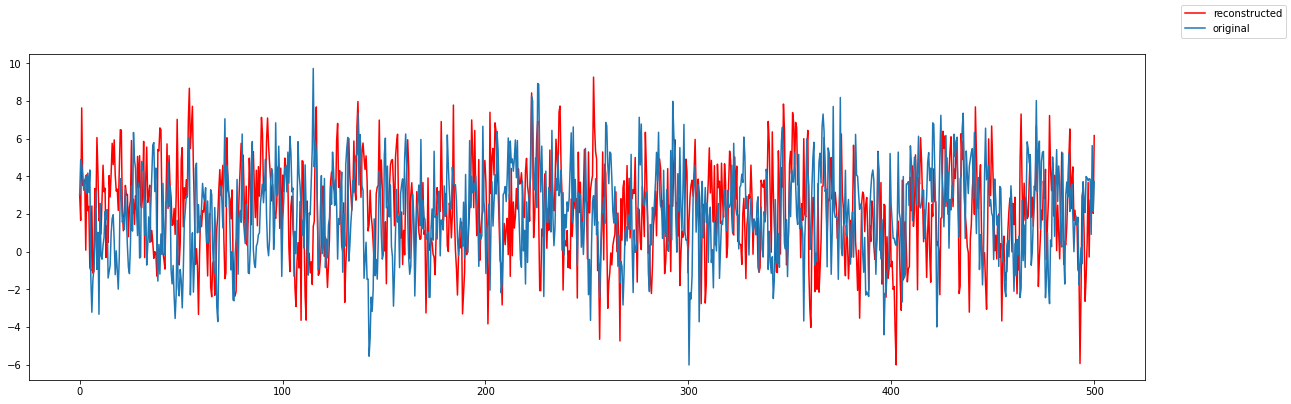

In [6]:
# plot the reconstructed data
params_mle_3 = np.append(params_mle, [x_init])
X_rec = sim_OU(params_mle_3, time=t)

# plot data
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X_rec, 'r', label = "reconstructed")
ax.plot(t, X, label = "original")
fig.legend()
plt.show()

### Kalman Filter in Parameter Estimation of OU Process

In [7]:
def Kalman_OU(Y, x0, P0, theta, mu, sigma, dt):
    N = len(Y)
    xs = np.zeros(N)
    Ps = np.zeros(N)

    alpha = theta * mu * dt
    beta = 1 - theta * dt
    var_eta = sigma**2 * dt
    var_eps = 1e-4  # Measurement noise, adjust as needed

    x = x0
    P = P0
    loglikelihood = 0

    for k in range(N):
        # Prediction step
        x_p = alpha + beta * x
        P_p = beta**2 * P + var_eta

        # Update step
        r = Y[k] - x_p
        S = P_p + var_eps
        KG = P_p / S
        x = x_p + KG * r
        P = P_p * (1 - KG)
        loglikelihood += -0.5 * (np.log(2 * np.pi * S) + (r**2 / S))

        xs[k] = x
        Ps[k] = P

    return xs, Ps, loglikelihood

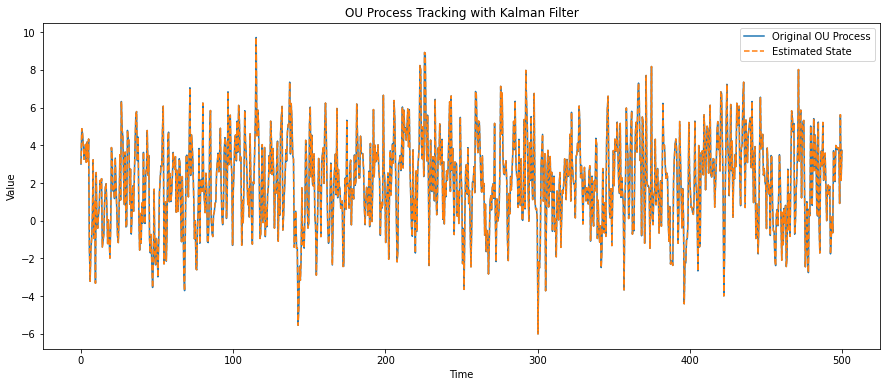

In [8]:
theta = 1  # Mean reversion speed
mu = 2     # Long-term mean
sigma = 3  # Volatility
dt = t[1] - t[0]

guess_theta = 0.5
guess_mu = 2.0
guess_sigma = 3.0

# Initial guesses for the state and its uncertainty
x0 = 3
P0 = 1

estimated_states, state_uncertainties, loglikelihood = Kalman_OU(X, x0, P0, theta, mu, sigma, dt)

plt.figure(figsize=(15, 6))
plt.plot(t, X, label='Original OU Process')
plt.plot(t, estimated_states, label='Estimated State', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('OU Process Tracking with Kalman Filter')
plt.legend()
plt.show()


In [9]:
def minus_likelihood_OU(params):
    theta, mu, sigma = params
    dt = 0.5  # Assuming a constant time step, adjust as needed
    _, _, loglik = Kalman_OU(X, x0, P0, theta, mu, sigma, dt)
    return -loglik

# Set initial guesses
guess_theta = 0.5
guess_mu = 2.0
guess_sigma = 3.0

time_start = time.time()
result = minimize(
    minus_likelihood_OU,
    x0=[guess_theta, guess_mu, guess_sigma],
    method="L-BFGS-B",
    bounds=[(1e-15, 2), (1e-15, 5), (1e-15, 5)],
    tol=1e-12,
)
time_end = time.time()

optimized_theta, optimized_mu, optimized_sigma = result.x
print("Optimized parameters:", result)
print("Kalman filter parameter estimation running time (s): ", time_end - time_start)

Optimized parameters:       fun: 2158.2920607225883
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.81898941e-04, 4.09272618e-04, 4.54747354e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 10
     njev: 28
   status: 0
  success: True
        x: array([1.01615061, 2.05656307, 2.9621365 ])
Kalman filter parameter estimation running time (s):  0.28348326683044434


## 2. Black-Karasinski (BK) Model with Purely Brownian Noise

In [10]:
def bk(x, theta, alpha, sigma, dt):
    dx=(theta-alpha*x)*dt+sigma*np.random.normal(0,np.sqrt(dt))
    #print(dx)
    return dx

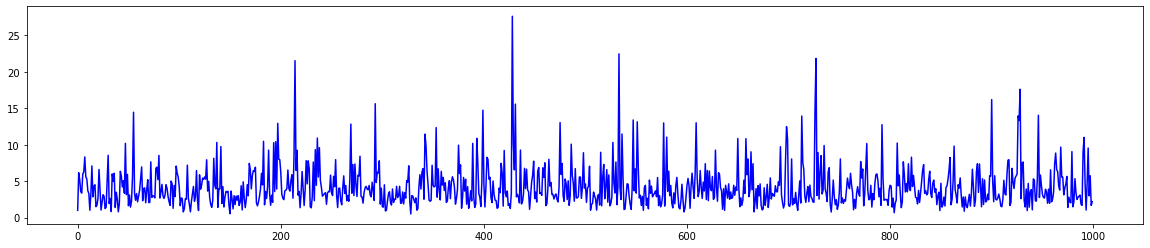

In [11]:
r=1
dt=1
theta=1
alpha=0.8
sigma=0.6

N= 1000

value_list=np.zeros(N)

for i in range(0,N-1):
  #value=bk(r,theta,alpha,sigma,dt)
  #print("round",i+1, "value is", value)
  value_list[i+1]=value_list[i]+bk(value_list[i], theta, alpha, sigma, dt)

#print(value_list)


value_list=np.exp(value_list)

x_axis=range(0,N)
plt.figure().set_figwidth(20)
plt.plot(x_axis, value_list,'b')

#plt.show()

#print("algebric mean is", np.mean(value_list))

In [12]:
X=value_list.copy()

from scipy.optimize import minimize
#  Code our distribution function
def BKK(x1, x2, dt, theta, alpha, sigma):
    #sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    #sigma0 = np.sqrt( sigma0 )

    prefactor = 1 / (np.sqrt(2 * np.pi * sigma**2 * dt))

    #f =  prefactor * np.exp( -(x2 - x1 * np.exp(-mu*dt) - theta * (1-np.exp(-mu*dt)) )**2 / (2 * sigma0**2) )

    f= prefactor * np.exp(-1/2 *  ((x2 - x1 - (theta - alpha * x1)*dt)**2 /(dt * sigma**2)))
    return f

#  Calculate the negative of the log likelihood
def log_likelihood_BK(p, X, dt):

    theta = p[0]
    alpha = p[1]
    sigma = p[2]

    #N = 1000

    f = np.zeros( (N-1, ) )

    for i in range( 1, N ):
        x2 = np.log(X[i])
        x1 = np.log(X[i-1])

        f[i-1] = BKK(x1, x2, dt, theta, alpha, sigma)

    ind = np.where(f == 0)
    ind = ind[0]
    if ind.size > 0:
        f[ind] = 10**-8

    f = np.log(f)
    f = np.sum(f)

    return -f

#  mu and sigma must be greater than zero.  We use these contraint functions with minimze
def constraint1( p ):
    return p[1]

def constraint2( p ):
    return p[2]

#  Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

#  Initial guess for our parameters
p0 = [0.1, 1, 0.3]

#  Call minimize
min_like=minimize(log_likelihood_BK, p0, args = (X, dt), constraints=cons)


bk_like_list=min_like.x

print("We set original [theta, alpha, sigma] for BK to be " ,[theta, alpha, sigma])

print("MLE [theta, alpha, sigma] for BK is ", bk_like_list)

We set original [theta, alpha, sigma] for BK to be  [1, 0.8, 0.6]
MLE [theta, alpha, sigma] for BK is  [1.0124178  0.80167654 0.58993636]


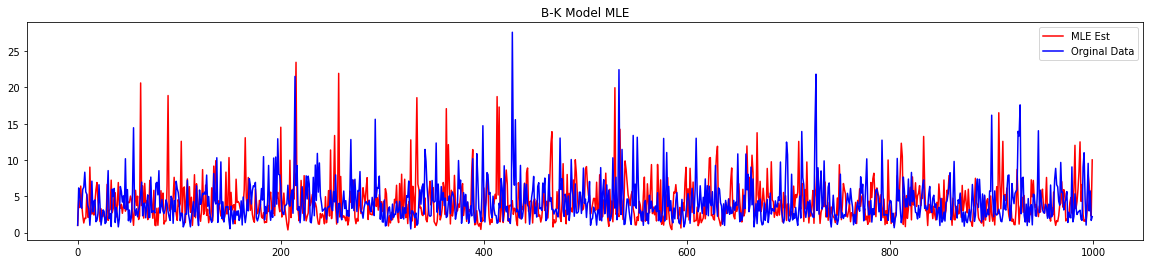

In [13]:
r=1
dt=1
theta=bk_like_list[0]
alpha=bk_like_list[1]
sigma=bk_like_list[2]
new_value_list=np.zeros(N)
for i in range(0,N-1):
    new_value=bk(r,theta,alpha,sigma,dt)
    #print("round",i+1, "value is", value)
    new_value_list[i+1]=new_value_list[i]+bk(new_value_list[i], theta, alpha, sigma, dt)

new_value_list=np.exp(new_value_list)

#print(value_list)
x_axis=range(0,N)
plt.figure().set_figwidth(20)

plt.plot(x_axis, new_value_list,'r',label="MLE Est")
plt.plot(x_axis, value_list,'b',label="Orginal Data") #original values
plt.title("B-K Model MLE")
plt.legend()
plt.show()

## 3. OU Process with Jump, in Addition to Brownian Noise
One can make the OU process a more realistic model by adding a jump term into the SDE. This noise addition makes MLE more difficult, because the likelihood function can no longer be easily computed analytically.

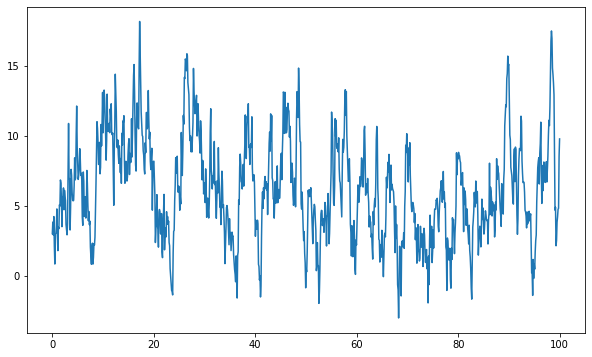

In [14]:
# genrate data, OU process discretized
# dX_t = theta (mu - X_t) dt + sigma dW_t + J_t
N = 1000 # data size
t = np.linspace(0, 100, N) # time

# set parameters manually first, we look to reconstruct them
theta = 1
mu = 2
sigma = 4
x_init = 3

lambda_j = 0.5
mu_j = 1
sigma_j = 1

# Euler-Maruyama
def sim_OU_jump(params, time):
    theta, mu, sigma, x_init = (params[0], params[1], params[2], params[3])
    lambda_j, mu_j, sigma_j = (params[4], params[5], params[6])
    X_j = np.zeros(time.shape[0])
    X_j[0] = x_init
    for i in range(time.shape[0]-1):
        dt = time[i+1] - time[i]
        X_j[i+1] = X_j[i] + theta * (mu - X_j[i]) * dt + sigma * np.random.normal(0, np.sqrt(dt))
        if np.random.normal(0, 1) < lambda_j * dt:
            X_j[i+1] += np.random.normal(mu_j, sigma_j)

    return X_j

# plot data
X_jump = sim_OU_jump(params=[theta, mu, sigma, x_init, lambda_j, mu_j, sigma_j], time = t)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(t, X_jump)

It's necessary to take the jumps into account in parameter estimation. In the current setting, one can actually still compute the likelihood function. Our updating scheme is $$X_{i+1} = X_i + \theta(\mu-X_i)dt + \sigma Z_i + J_i$$ where $Z_i \sim N(0, dt)$ and each $J_i$ behaves independently such that:

- the probability that $J_i$ is activated is the standard normal cumulative distribution function $F_N$ at $\lambda_j dt$, and
- when it is, it takes a value from the normal distribution $N(\mu_j, \sigma_j^2)$

When $J_i = 0$, $X_{i+1}$ still follows the distribution as in the simple OU process. When $J_i \ne 0$, $X_{i+1}$ follows the sum of the two normal distributions, which is in turn a normal distribution centered at $[X_{i}+\theta(\mu-X_i)] + \mu_j$, with variance $\sigma^2 dt + \sigma_j^2$

Therefore, given $X_i$,

$$\begin{align}
    P(X_{i+1}|X_i) &= P(X_{i+1}, J_i = 0| X_i) + P(X_{i+1}, J_i \ne 0| X_i) \\
    &= P(X_{i+1} | J_i = 0, X_i) \cdot P(J_i = 0) + P(X_{i+1} | J_i \ne 0, X_i)\cdot P(J_i \ne 0) \\
    &= (1-F_N(\lambda_j dt))\cdot \frac{1}{\sqrt{2\pi dt}\sigma} \cdot\exp\left\{-\frac{1}{2}\left(\frac{X_{i+1}-[X_{i}+\theta(\mu-X_i)dt]}{\sigma\sqrt{dt}}\right)^2\right\} dx \\
    &+ F_N(\lambda_j dt)\cdot \frac{1}{\sqrt{2\pi(\sigma^2 dt + \sigma_j^2)}} \cdot \exp \left\{ -\frac{1}{2} \left(\frac{X_{i+1} - [X_{i}+\theta(\mu-X_i)dt + \mu_j]}{\sqrt{\sigma^2 dt + \sigma_j^2}}\right)^2 \right\} dx
    \end{align}
$$

The $dx$ term can be omitted in the likelihood function, because regardless of parameter choice, the $dx$ terms are unchanged. One can use the above formula to compute and optimize likelihood functions.

In [15]:
def likelihood_jump_normal(params, data, time):
    """
    Computes analytically the negative log likelihood of the OU process with normally distributed jump term.
    Input:
    - params: parameters of the model, ordered in [theta, mu, sigma, lambda_j, mu_j, sigma_j]
    - data: time series data
    - time: time vector, used to compute dt
    Output:
    - negative log likelihood value
    """
    theta = params[0]
    mu = params[1]
    sigma = params[2]
    lambda_j, mu_j, sigma_j = (params[3], params[4], params[5])
    log_likelihood = 0
    for j in range(1, data.shape[0]-1):
        dt = time[j] - time[j-1]
        log_likelihood = log_likelihood + \
                         np.log(normal_pdf(data[j-1]+theta*(mu-data[j-1])*dt, sigma**2*dt, data[j]) * (1-norm.cdf(lambda_j * dt)) + \
                         normal_pdf(data[j-1]+theta*(mu-data[j-1])*dt + mu_j, sigma**2*dt + sigma_j**2, data[j]) * (norm.cdf(lambda_j * dt)))

    return -log_likelihood

In [16]:
bound=[(1e-15, 6), (1e-15, 6), (1e-15, 6), (1e-15, 6), (1e-15, 6), (1e-15, 6)]
start = time.time()
params_jump_mle_1 = scipy.optimize.minimize(likelihood_jump_normal, x0 = [1,1.5,2,1,0.5,0.5], args=(X_jump, t), bounds = bound).x.round(decimals=3)
end = time.time()
print("Reconstructed paramaters: [theta, mu, sigma, lambda_j, mu_j, sigma_j] =", params_jump_mle_1)
print("Original parameters:      [theta, mu, sigma, lambda_j, mu_j, sigma_j] =", [theta, mu, sigma, lambda_j, mu_j, sigma_j])
print("MLE running time (s):    ", end-start)

Reconstructed paramaters: [theta, mu, sigma, lambda_j, mu_j, sigma_j] = [0.99  0.    3.217 5.229 0.885 1.292]
Original parameters:      [theta, mu, sigma, lambda_j, mu_j, sigma_j] = [1, 2, 4, 0.5, 1, 1]
MLE running time (s):     38.66627526283264


[0.99  0.    3.217 3.    5.229 0.885 1.292]


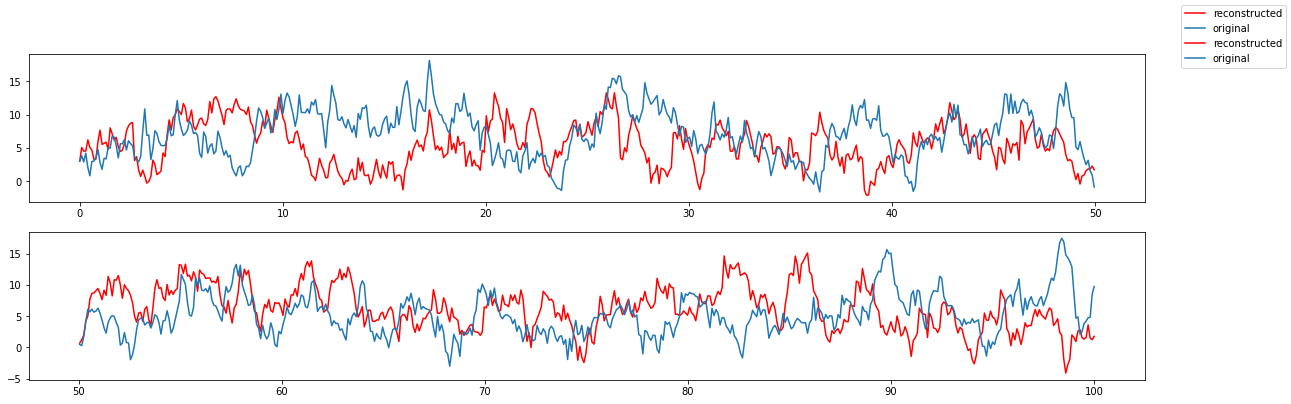

In [17]:
# plot the reconstructed data
params_rec_cplt = np.insert(params_jump_mle_1, 3, x_init)
print(params_rec_cplt)

X_jump_rec = sim_OU_jump(params = params_rec_cplt, time = t)
# plot data
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(2,1,1)
ax.plot(t[:500], X_jump_rec[:500], 'r', label = "reconstructed")
ax.plot(t[:500], X_jump[:500], label = "original")
ax_2 = fig.add_subplot(2,1,2)
ax_2.plot(t[500:], X_jump_rec[500:], 'r', label = "reconstructed")
ax_2.plot(t[500:], X_jump[500:], label = "original")
fig.legend()
plt.show()

## 4. Kalman Filter in Parameter Estimation of OU Process with Jumps

In [18]:
def Kalman_OU_with_jumps(Y, x0, P0, theta, mu, sigma, lambda_j, mu_j, sigma_j, dt):
    N = len(Y)
    xs = np.zeros(N)
    Ps = np.zeros(N)

    var_eta = sigma**2 * dt + lambda_j * mu_j**2 * dt  # Example adjustment
    var_eps = 1e-4  # Measurement noise, adjust as needed

    x = x0
    P = P0
    loglikelihood = 0

    for k in range(N):
        # Prediction step (OU process without jump component)
        alpha = theta * mu * dt
        beta = 1 - theta * dt
        x_p = alpha + beta * x
        P_p = beta**2 * P + var_eta

        # Update step
        r = Y[k] - x_p
        S = P_p + var_eps
        KG = P_p / S
        x = x_p + KG * r
        P = P_p * (1 - KG)
        loglikelihood += -0.5 * (np.log(2 * np.pi * S) + (r**2 / S))

        xs[k] = x
        Ps[k] = P

    return xs, Ps, loglikelihood

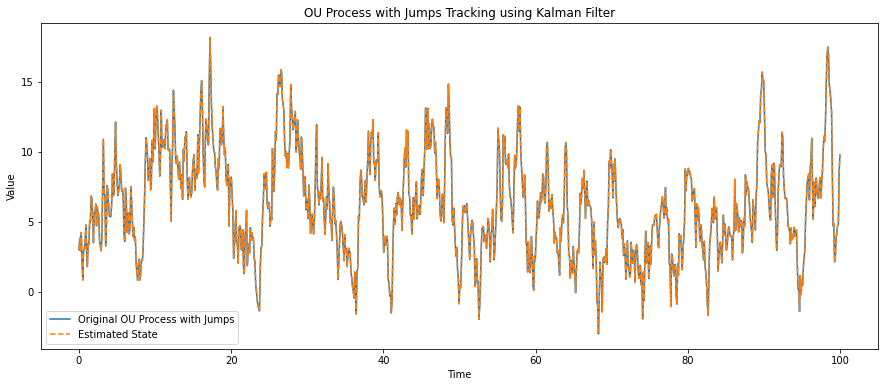

In [19]:
dt = t[1] - t[0]  # Assuming a constant time step
estimated_states, state_uncertainties, loglikelihood = Kalman_OU_with_jumps(X_jump, x_init, 10, theta, mu, sigma, lambda_j, mu_j, sigma_j, dt)

plt.figure(figsize=(15, 6))
plt.plot(t, X_jump, label='Original OU Process with Jumps')
plt.plot(t, estimated_states, label='Estimated State', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('OU Process with Jumps Tracking using Kalman Filter')
plt.legend()
plt.show()

In [20]:
def minus_likelihood_OU(params):
    theta, mu, sigma, lambda_j, mu_j, sigma_j = params
    dt = t[1] - t[0]
    _, _, loglik = Kalman_OU_with_jumps(X_jump, x_init, 10, theta, mu, sigma, lambda_j, mu_j, sigma_j, dt)
    return -loglik

guess_theta = 0.5
guess_mu = 2.0
guess_sigma = 3.0
guess_lambda_j = 0.5
guess_mu_j = 1.0
guess_sigma_j = 1.0

start = time.time()
result = minimize(
    minus_likelihood_OU,
    x0=[guess_theta, guess_mu, guess_sigma, guess_lambda_j, guess_mu_j, guess_sigma_j],
    method="L-BFGS-B",
    bounds=[(1e-15, 2), (1e-15, 5), (1e-15, 5), (1e-15, 1), (1e-15, 1.5), (1e-15, 5)],
    tol=1e-12,
)
end = time.time()

optimized_params = result.x
optimized_theta, optimized_mu, optimized_sigma, optimized_lambda_j, optimized_mu_j, optimized_sigma_j = optimized_params
print("Optimized parameters:", result)
print("Kalman filter parameter estimation running time (s): ", end-start)

Optimized parameters:       fun: 1853.1943368443463
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.89843538e+00, -2.27373677e-05,  6.82121023e-05,
        1.59161574e-04,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([0.85775715, 5.        , 4.71055914, 0.89743022, 1.33574057,
       1.        ])
Kalman filter parameter estimation running time (s):  0.19933414459228516
